# parsing configuration file

In [19]:
import configparser
confParser = configparser.ConfigParser()

In [20]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

#--- set dynamic parameters
temp=confParser['parameters']['temperature']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


conf. file sections: ['parameters', 'flags', 'input files', 'Atomic Radius']


# import libraries

In [21]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import LammpsPostProcess2nd as lpp
import utilityy as utll
import utility as utl
from utility import *
import imp
imp.reload(lp)
imp.reload(lpp)
imp.reload(utl)
imp.reload(utll)

<module 'utilityy' from '/Users/Home/Desktop/Tmp/txt/git/vacancyDiffusion/postproc/../../HeaDef/postprocess/utilityy.py'>

In [22]:
class Symbols:
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs
    
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!


# Dump File

In [49]:
!rm -r dumpFile;mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'
outpt_headers = 'dumpFile/calcResults.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = sys.maxsize, 
                )
print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Barrier", "Energy", "Step", "Time"])

InputFile= ../simulations/CantorNatom16KTemp1000K/Run0/allconf
num_frames= 159
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20
frame=21
frame=22
frame=23
frame=24
frame=25
frame=26
frame=27
frame=28
frame=29
frame=30
frame=31
frame=32
frame=33
frame=34
frame=35
frame=36
frame=37
frame=38
frame=39
frame=40
frame=41
frame=42
frame=43
frame=44
frame=45
frame=46
frame=47
frame=48
frame=49
frame=50
frame=51
frame=52
frame=53
frame=54
frame=55
frame=56
frame=57
frame=58
frame=59
frame=60
frame=61
frame=62
frame=63
frame=64
frame=65
frame=66
frame=67
frame=68
frame=69
frame=70
frame=71
frame=72
frame=73
frame=74
frame=75
frame=76
frame=77
frame=78
frame=79
frame=80
frame=81
frame=82
frame=83
frame=84
frame=85
frame=86
frame=87
frame=88
frame=89
frame=90
frame=91
frame=92
frame=93
frame=94
frame=95
frame=96
frame=97
frame=98
frame=99
frame=100
frame=101
frame=102
f

,id,type,x,y,z
0,1,2,16.135925,12.542981,50.260193
1,2,1,30.432163,12.503089,25.087652
2,3,4,16.150433,32.352161,37.694412
3,4,5,12.512427,19.720429,14.335161
4,5,4,21.543015,12.540252,23.266426


In [296]:
def AddRndStrs(df):
    df['sxx']=np.random.normal(size=len(df))
    df['syy']=np.random.normal(size=len(df))
    df['szz']=np.random.normal(size=len(df))

#--- add random stress
#list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


[None, None]

# Displacements

In [24]:
def WrapperDisp(lmpData,reference_frames,current_frames):
    '''
    invoke disp analysis in ovito
    '''
    #--- split dump file
    for ii0, ii in zip(reference_frames,current_frames):
        atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
        atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
        lpp.WriteDumpFile(atom_current, box).Write('disp/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
        lpp.WriteDumpFile(atom_reference, box0).Write('disp/dump_ref.xyz', itime=ii0,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
    #    os.system('tar czf dump.gz dump.xyz')
        fileCurr = 'disp/dump_curr.xyz'
        fileRef = 'disp/dump_ref.xyz'
        output = 'disp/disp.%s.xyz'%ii
        #--- load to ovito
        os.system('ovitos %s/OvitosCna.py %s %s 2 8 %s'%(lib_path,fileCurr,output,fileRef))
        #--- concat
        os.system('cat %s >> disp/disp.xyz;rm %s'%(output,output))
        
        
        

!mkdir disp

#--- fetch parameters
lib_path = confParser['input files']['lib_path']
outpt = 'disp/disp.xyz'
!rm $outpt

current_frames = np.array(list(lmpData.coord_atoms_broken.keys()))[::2] #--- ignore half steps
current_frames.sort()
print('current_frames=',current_frames)
#--- reference
reference_frames = [current_frames[0]]*len(current_frames)
print('reference_frames=',reference_frames)
    
    
#--- call ovito
WrapperDisp(lmpData,reference_frames,current_frames)


#--- parse dump files
print('parsing %s'%(outpt))
lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
lmpDisp.GetCords( ncount = sys.maxsize )
display(lmpDisp.coord_atoms_broken[0].head())


mkdir: disp: File exists
current_frames= [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158]
reference_frames= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile=

,id,type,x,y,z,DisplacementX,DisplacementY,DisplacementZ
0,1,2,16.135925,12.542981,50.260193,0.0,0.0,0.0
1,2,1,30.432163,12.503089,25.087652,0.0,0.0,0.0
2,3,4,16.150433,32.352161,37.694412,0.0,0.0,0.0
3,4,5,12.512427,19.720429,14.335161,0.0,0.0,0.0
4,5,4,21.543015,12.540252,23.266426,0.0,0.0,0.0


## msd vs. time

In [117]:
class MsDisp:
    
    def __init__(self, lmpDisp):
        self.disp = lmpDisp.coord_atoms_broken
        
        self.times = list(lmpDisp.coord_atoms_broken.keys())
        self.times.sort()
    
    def Get(self):
        msd = list(map(lambda x:(self.disp[x]['DisplacementX']**2+\
                     self.disp[x]['DisplacementY']**2+\
                     self.disp[x]['DisplacementZ']**2).mean(),
                self.times))
        return np.array(msd)
        

    def WindowAverage(self,ttime,bins_per_decade=4):
        for shift in range(1,len(self.times)-1):
    #        shift = 1 #--- time index  shift
            dt = zip(self.times,self.times[shift:]) #--- time tuples
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            disp = list(map(lambda x: ((self.disp[x[1]]['DisplacementX']-self.disp[x[0]]['DisplacementX'])**2+\
                          (self.disp[x[1]]['DisplacementY']-self.disp[x[0]]['DisplacementY'])**2+\
                          (self.disp[x[1]]['DisplacementZ']-self.disp[x[0]]['DisplacementZ'])**2).mean(),
                zip(self.times,self.times[shift:])))
            
#            print(np.c_[dt_real,disp].shape)
            if shift == 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)
                
                
                
        #--- binning
        xmin = 0.99*tr_mat[:,0].min()
        xmax = 1.01*tr_mat[:,0].max()
        n_decades = int(np.ceil(np.log10(xmax/xmin)))
        bins = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        #
        ysum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
        ysum_sq, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
        xsum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
        count, edges = np.histogram(tr_mat[:,0],bins=bins)
        #
        filtr = count > 1
        ysum = ysum[filtr]
        ysum_sq = ysum_sq[filtr]
        xsum = xsum[filtr]
        count = count[filtr]
        assert not np.any(count == 0), 'incerease bin size!'
        #
        ysum_sq /= count
        ysum /= count
        xsum /= count
        ysum_sq -= (ysum * ysum)
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[xsum,ysum,(ysum_sq/count)**0.5]

msd = MsDisp( lmpDisp )
ans = msd.WindowAverage(lmpData.times,bins_per_decade=4)

!mkdir msd
with open('msd/msd.txt','w') as fp:
    np.savetxt(fp,ans,header='t\tmsd\terr')
with open('msd/event_times.txt','w') as fp:
    np.savetxt(fp,lmpData.times,header='t')

mkdir: msd: File exists


mkdir: png: File exists


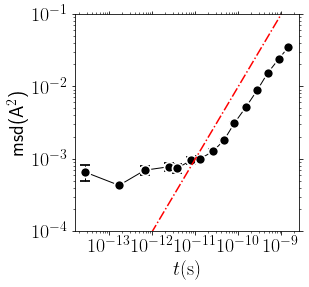

<AxesSubplot:xlabel='$t\\mathrm{(s)}$', ylabel='msd(A$^2$)'>

In [43]:
!mkdir png
symbols=utl.Symbols()
ax = utl.PltErr(ans[:,0],
                1e8*ans[:,0],
                attrs={'fmt':'-.r'},Plot=False)

utl.PltErr(ans[:,0],ans[:,1],
           yerr=ans[:,2],
           ax = ax,
           attrs=symbols.GetAttrs(count=0),
           Plot=False,
          )
utl.PltErr(None,#lmpData.times[1:],
           None, #msd.Get()[1:],
          xscale='log',
          yscale='log',
           attrs={'fmt':'-'},
           ax=ax,
           ylim=(1e-4,1e-1),
           xstr=r'$t\mathrm{(s)}$',
           ystr=r'msd(A$^2$)',
           title='png/msd.png'
          )

## arrhenius law

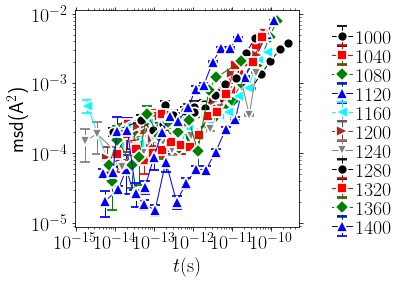

Temp=1000,x0,y0,c0,alpha [7.45400337e-08 5.62731131e-04 9.95732307e-01 9.99000000e-01]


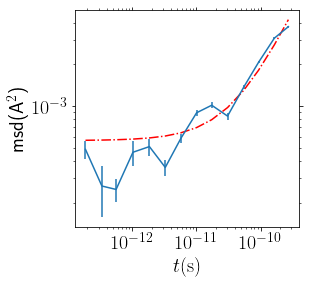

Temp=1040,x0,y0,c0,alpha [1.45435831e-08 3.20139332e-04 9.99998119e-01 9.99043671e-01]


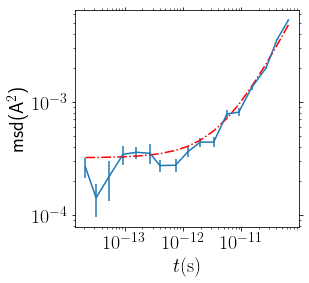

Temp=1080,x0,y0,c0,alpha [1.92517065e-08 8.45726996e-05 9.99997017e-01 1.00100000e+00]


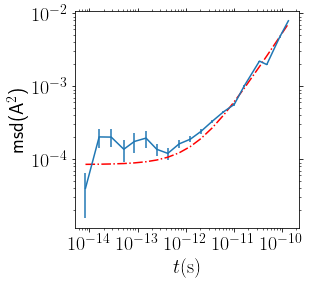

Temp=1120,x0,y0,c0,alpha [1.49461269e-08 1.86540914e-06 9.99998554e-01 1.00009409e+00]


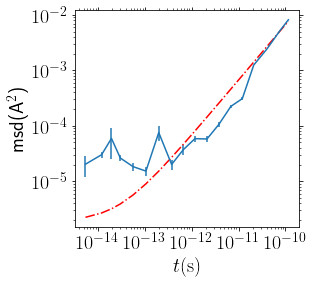

Temp=1160,x0,y0,c0,alpha [2.58189833e-08 1.04241655e-04 9.99996141e-01 1.00100000e+00]


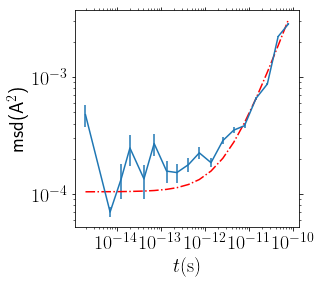

Temp=1200,x0,y0,c0,alpha [1.55874391e-08 1.99655312e-04 9.99998600e-01 9.99033672e-01]


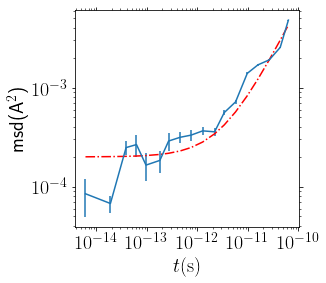

Temp=1240,x0,y0,c0,alpha [4.39137963e-08 9.02021934e-05 9.99995730e-01 9.99072290e-01]


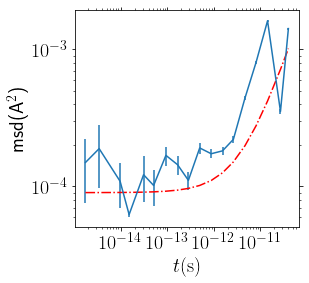

Temp=1280,x0,y0,c0,alpha [1.03142674e-08 4.68564809e-04 9.99998618e-01 9.99043560e-01]


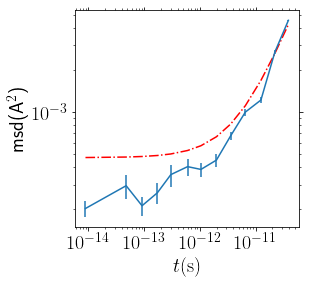

Temp=1320,x0,y0,c0,alpha [1.35712377e-08 1.26259984e-04 9.99998886e-01 9.99023873e-01]


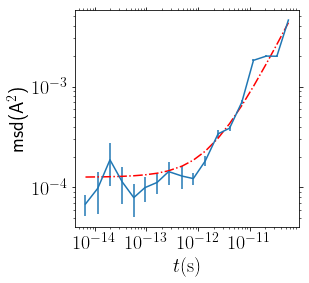

Temp=1360,x0,y0,c0,alpha [6.96375284e-09 8.07040404e-05 9.99999265e-01 1.00049995e+00]


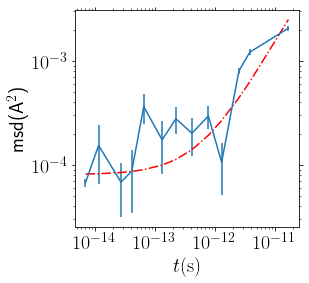

Temp=1400,x0,y0,c0,alpha [2.69646461e-09 8.59940513e-05 9.99999730e-01 9.99000001e-01]


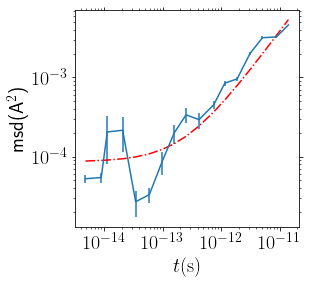

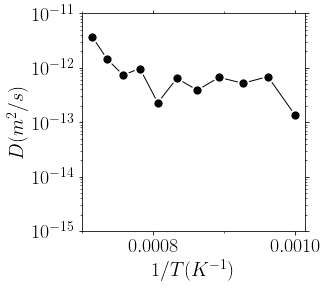

In [99]:
class Temperature:
    
    def __init__(self,temp_range):
        self.temps =  temp_range
    
    def Parse(self,dirs):
        self.data=list(map(lambda x:np.loadtxt(x),dirs))
        
        
    def Plot(self):
        ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))

        for data, temp, count in zip(self.data,self.temps,range(len(self.data))): 
            utl.PltErr(data[:,0],data[:,1],
                   yerr=data[:,2],
                   ax = ax,
                   attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
                   Plot=False,
                  )

        utl.PltErr(None,#lmpData.times[1:],
                   None, #msd.Get()[1:],
                  xscale='log',
                  yscale='log',
                   attrs={'fmt':'-'},
                   ax=ax,
#                    ylim=(1e-6,1e-2),
                   xstr=r'$t\mathrm{(s)}$',
                   ystr=r'msd(A$^2$)',
                   title='png/msd_temp.png',
                    legend=legends.Get()
                  )
        
    def func(self,x,x0,y0,c0,alpha):
        return y0+c0*(x/x0)**alpha

    def Fit(self,Plot=None,verbose=None):
        self.Diffusion = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2

        for smat, temp, count in zip(self.data,self.temps,range(len(self.data))): 

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
            popt, pcov = curve_fit(self.func, xdata, ydata, 
                                   bounds=([0, 0, 0,0.999], [1e-2, 1., 1,1.001]),
                                    sigma=yerr,
                                    )
            if verbose:
                print('Temp=%s,x0,y0,c0,alpha'%temp,popt)
            c0=popt[2]
            tau=popt[0]
            self.Diffusion[temp] = pref*c0/tau

            if Plot:
                ax = utl.PltErr(xdata,
                                self.func(xdata,*popt),
                                attrs={'fmt':'-.r'},Plot=False)
                utl.PltErr(xdata,
                           ydata,
                           yerr=yerr,
                          xscale='log',
                          yscale='log',
                           attrs={'fmt':'-'},
                           ax=ax,
            #               ylim=(1e-4,1e-1),
                           xstr=r'$t\mathrm{(s)}$',
                           ystr=r'msd(A$^2$)',
                #           title='png/msd.png',
                #           legend=legends.Get()
                          )

    def PlotDiff(self):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x],self.temps)),
                  yscale='log',
                   attrs=symbols.GetAttrs(),
                   ylim=(1e-15,1e-11),
                   xstr=r'$1/T(K^{-1})$',
                   ystr=r'$D(m^2/s)$',
                   title='png/D_temp.png',
                  )

if not eval(confParser['flags']['RemoteMachine']):
    temp = Temperature( #[1240],
                       list(map(int,np.linspace(1000,1400,11))),
                      )
    temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sK/Run0/msd/msd.txt'%x,temp.temps))
              )
    temp.Plot()
    temp.Fit(Plot=True,verbose=True)
    temp.PlotDiff()


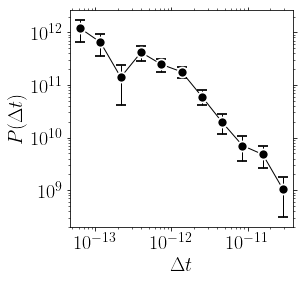

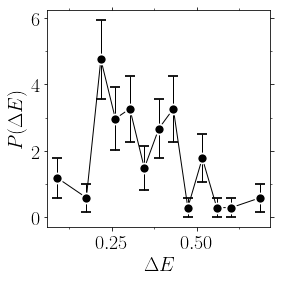

In [97]:
class Stats:
    def __init__(self,lmpData):
        self.lmpData=lmpData
    #
    def PlotWaitTimes(self):
        times = np.array(np.c_[self.lmpData.headers['Time'].iloc[0::2]].flatten())
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
        filtr = dtt > 0.0
        hist, bin_edges, err = utl.GetPDF(dtt[filtr],n_per_decade=4)
        utl.PltErr(bin_edges,hist,
                  yerr=err,
                   attrs=symbols.GetAttrs(),
                   yscale='log',
                   xscale='log',
                   xstr=r'$\Delta t$',
                   ystr=r'$P(\Delta t)$'
                  )
    #
    def Barries(self):
        Barrier = self.lmpData.headers['Barrier'].iloc[1::2]        
        hist, bin_edges, err = utl.GetPDF(Barrier,linscale=True,n_per_decade=16)
        utl.PltErr(bin_edges,hist,
                  yerr=err,
                   attrs=symbols.GetAttrs(),
                   #yscale='log',
                   #xscale='log',
                   xstr=r'$\Delta E$',
                   ystr=r'$P(\Delta E)$'
                  )
stats = Stats(lmpData)
stats.PlotWaitTimes()
stats.Barries()

In [84]:
help(utl.GetPDF)

Help on function GetPDF in module utility:

GetPDF(slist, n_per_decade=4, ACCUM=None, linscale=None, density=True)



In [68]:
Energy = lmpData.headers['Energy']

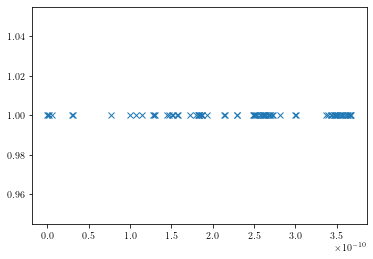

In [71]:
plt.plot(times,np.ones(len(times)),'x')

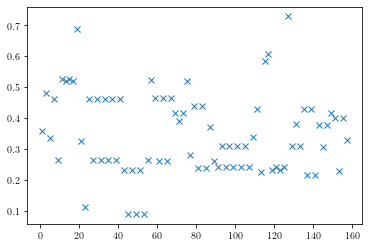

In [91]:
plt.plot(Barrier,'x')

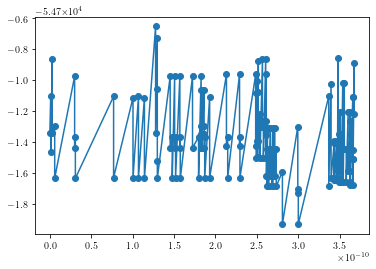

In [95]:
plt.plot(lmpData.headers['Time'],Energy,'-o')